In [1]:
import os
import numpy as np
from phathom import io
from phathom.preprocess import filtering
from phathom.phenotype import celltype
from phathom import plotting
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
working_dir = '/media/jswaney/Drive/Justin/organoid_etango/'

# Smooth the cell-type markers

In [4]:
zarr_paths = ['syto16_test.zarr',
              'sox2_test.zarr',
              'tbr1_test.zarr']
smooth_zarr_paths = ['syto16_test_smooth.zarr',
                       'sox2_test_smooth.zarr',
                       'tbr1_test_smooth.zarr']
sigma = (1.2, 3.0, 3.0)
chunks = (128, 128, 128)
overlap = 8
nb_workers = 1

In [5]:
arrs = []
smooth_arrs = []
for zarr_path, smooth_zarr_path in zip(zarr_paths, smooth_zarr_paths):
    arr = io.zarr.open(os.path.join(working_dir, zarr_path))
    smooth_zarr = io.zarr.new_zarr_like(os.path.join(working_dir, 
                                                     smooth_zarr_path), 
                                        arr)
    arrs.append(arr)
    smooth_arrs.append(smooth_zarr)

In [6]:
for i, o in zip(arrs, smooth_arrs):
    filtering.gaussian_blur_parallel(i, 
                                     sigma, 
                                     o, 
                                     chunks, 
                                     overlap, 
                                     nb_workers)

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


# Sample signals at cell centers

In [7]:
centers_path = 'centers.npy'

centers = np.load(os.path.join(working_dir, centers_path))
centers.shape

(39459, 3)

In [8]:
radius = 1

mfi = np.zeros((centers.shape[0], len(smooth_zarr_paths)))
stdev = np.zeros((centers.shape[0], len(smooth_zarr_paths)))

for i, path in enumerate(smooth_zarr_paths):
    arr = io.zarr.open(os.path.join(working_dir, path))
    intensities = celltype.nuclei_centered_intensities(arr, 
                                                       centers, 
                                                       radius)
    mfi[:, i] = celltype.calculate_mfi(intensities)
    stdev[:, i] = celltype.calculate_stdev(intensities)

100%|██████████| 39459/39459 [00:24<00:00, 1612.31it/s]


<IPython.core.display.Javascript object>


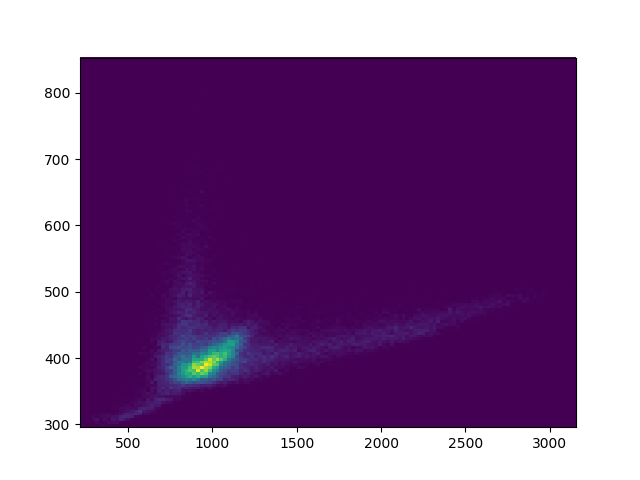

In [30]:
_range = None
plotting.plot_hist_2d(mfi[:, 1], mfi[:, 2], bins=128, range=_range)

In [43]:
sox2_threshold = 1400
tbr1_threshold = 510

sox2_idx = np.where(mfi[:, 1] > sox2_threshold)[0]
tbr1_idx = np.where(mfi[:, 2] > tbr1_threshold)[0]

<IPython.core.display.Javascript object>


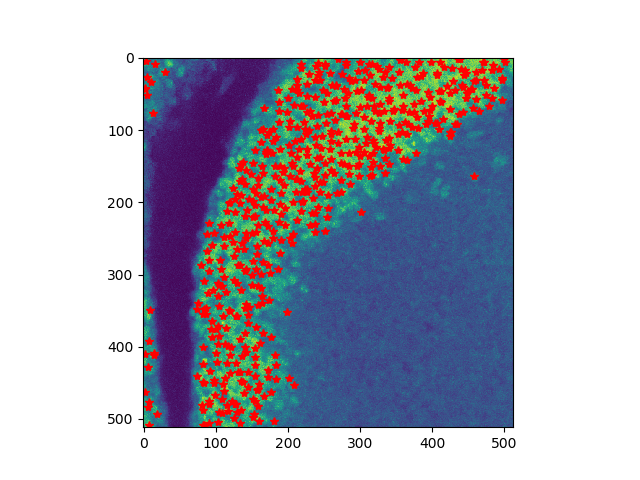

In [37]:
plotting.zprojection(arrs[1], centers[sox2_idx], zlim=[10, 20])

<IPython.core.display.Javascript object>


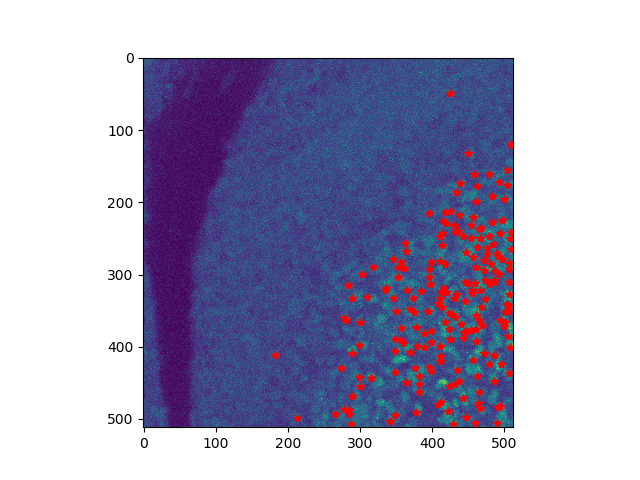

In [44]:
plotting.zprojection(arrs[2], centers[tbr1_idx], zlim=[10, 20])

In [47]:
sox2_labels = celltype.threshold_mfi(mfi[:, 1], sox2_threshold)
tbr1_labels = celltype.threshold_mfi(mfi[:, 2], tbr1_threshold)

# Save the results

In [48]:
sox2_path = 'sox2_labels.npy'
tbr1_path = 'tbr1_labels.npy'

np.save(os.path.join(working_dir, sox2_path), sox2_labels)
np.save(os.path.join(working_dir, tbr1_path), tbr1_labels)